In [1]:
from jax import config
config.update("jax_debug_nans", True)
config.update("jax_enable_x64", True)

from pathlib import Path

from matplotlib import pyplot as plt
import numpy as np

from src.lib_phaseshifts import readPHASESHIFTS
from src.lib_tensors import *
from src.lib_delta import *
from src.delta import *
from src.utils import *
from src.hashable_array import HashableArray

#%matplotlib widget

In [2]:
#From "PARAM"
LMAX = 14  # maximum angular momentum to be used in calculation
n_beams = 9  # no. of TLEED output beams
n_atoms = 1  # currently 1 is the only possible choice
n_geo = 1  # number of geometric variations ('displacements') to be considered

DR = 0.1908624 * BOHR

In [3]:
# unit vectors in Angstrom
u_vec1 = np.array([1.2722, -2.2036])
u_vec2 = np.array([1.2722,  2.2036])

# area of (overlayer) lateral unit cell - in case TLEED wrt smaller unit cell is used, TVA from reference computation must be set.
unit_cell_area = np.linalg.norm(np.cross(u_vec1, u_vec2))

In [4]:
IEL = 1  # element no. (in phase shifts supplied with input) that delta amplitudes
#          will be calculated for (not necessarily the same element as the one
#          used in the reference calculation!) - IEL = 0 means a vacancy will be assumed



In [5]:
phaseshifts_file = Path("Rough_Cu(111)/PHASESHIFTS")
T1_file = Path("Rough_Cu(111)/T_1")

In [6]:
_, phaseshifts, _, _ = readPHASESHIFTS(None, None, readfile=phaseshifts_file,
                                       check=False, ignoreEnRange=False)


In [7]:
n_energies = 0
with open(T1_file, 'r') as datei:
    for zeile in datei:
        if '-1' in zeile:
            n_energies += 1


In [8]:
tensor_data = read_tensor(T1_file, n_beams=9, n_energies= n_energies, l_max=LMAX+1)

# TODO: raise Error if requested energies are out of range respective to
# phaseshift energies (can't interpolate if out of range)

interpolated_phaseshifts = interpolate_phaseshifts(phaseshifts, LMAX, tensor_data.e_kin)

In [9]:
atom_phaseshifts = interpolated_phaseshifts[:, [IEL-1,], :]

In [10]:
delta_amp = lambda displacement: delta_amplitude(LMAX, np.array([DR,]),
                                                 HashableArray(tensor_data.e_kin),
                                                 (tensor_data,),
                                                 unit_cell_area,
                                                 HashableArray(atom_phaseshifts),
                                                 displacement)

In [11]:
my_delta = delta_amp(np.array([[0.05, 0.0, 0.0],]))

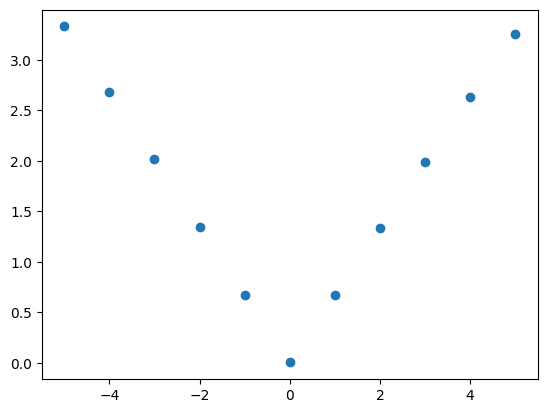

In [12]:
abs_amp = []
for d in range(-5, 6):
    abs_amp.append(np.sum(abs(delta_amp(np.array([[d*0.01, 0.0, 0.0],])))))

plt.scatter(range(-5, 6), abs_amp)

# Intensity

In [13]:
from src.lib_intensity import *

In [14]:
# Reference Amplitudes
ref_amps = tensor_data.ref_amps

beam_indices = np.array([[1, 0], [0, 1], [1, 1], [2, 0], [0, 2], [2, 1], [1, 2], [3, 0], [0, 3]])

trar = np.empty(shape=(2, 2), dtype="float")
trar[0, :] = [1.306759, -0.7544285]
trar[1, :] = [1.306759, 0.7544285]

v_real = tensor_data.v0r

theta, phi = 0.0, 0.0

is_surface_atom = np.array([True]) # topmost atom is surface atom

In [15]:
lam_prefactor = lambda displacement: intensity_prefactor(tensor_data.e_kin,
                                                         tensor_data.v0r,
                                                        tensor_data.v0i_substrate,
                                                         displacement,
                                                         beam_indices, theta, phi, trar, is_surface_atom)

In [16]:
e_inside = tensor_data.e_kin

In [17]:
delta_intensity = lambda displacement: sum_intensity(
    lam_prefactor(displacement), ref_amps, delta_amp(displacement)
)

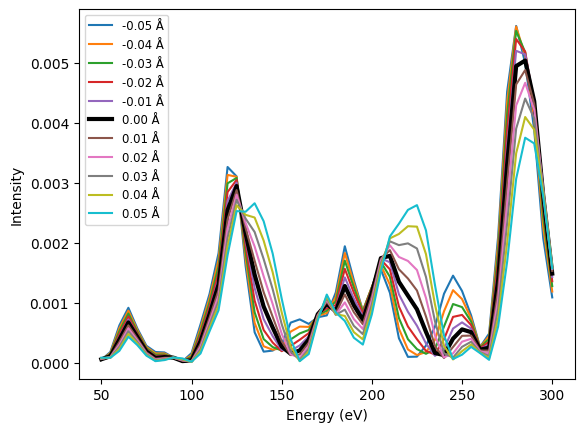

In [18]:
plt.figure()
for i in range(0, 11):
    if i == 5:
        disp = np.array([[-0.05 + 0.01* i, 0.0, 0.0]]) 
        plt.plot((tensor_data.e_kin-tensor_data.v0r)*HARTREE, delta_intensity(disp)[:,0],linewidth=3,color='black',label='0.00 Å')
    else:
        disp = np.array([[-0.05 + 0.01* i, 0.0, 0.0]]) 
        plt.plot((tensor_data.e_kin-tensor_data.v0r)*HARTREE, delta_intensity(disp)[:,0],label = str(np.round(-0.05 + 0.01* i,2)) + ' Å')

plt.xlabel("Energy (eV)")
plt.ylabel("Intensity")
plt.legend(fontsize='small')
plt.show()

c:\Users\haide\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


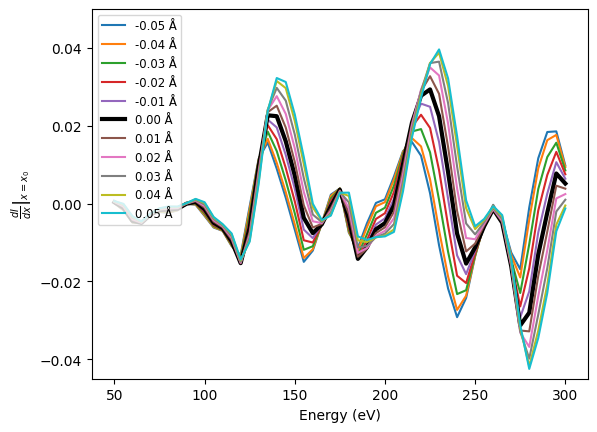

In [19]:
# plotting the numerical derivatives
plt.figure()
my_intensities = np.full(shape=(11,n_energies),dtype=np.complex128,fill_value=np.nan)
my_diffs = np.full(shape=(11,n_energies),dtype=np.complex128,fill_value=np.nan)
for i in range(11):
    disp = np.array([[-0.05 + 0.01* i, 0.0, 0.0]])
    my_intensities[i,:]=delta_intensity(disp)[:,0]
for j in range(n_energies):
    my_diffs[:,j] = np.gradient(my_intensities[:,j],0.01)

for i in range(0, 11):
    if i == 5:
        disp = np.array([[-0.05 + 0.01* i, 0.0, 0.0]]) 
        plt.plot((tensor_data.e_kin-tensor_data.v0r)*HARTREE, my_diffs[i,:],linewidth=3,color='black',label='0.00 Å')
    else:
        disp = np.array([[-0.05 + 0.01* i, 0.0, 0.0]]) 
        plt.plot((tensor_data.e_kin-tensor_data.v0r)*HARTREE, my_diffs[i,:],label = str(np.round(-0.05 + 0.01* i,2)) + ' Å')

plt.xlabel("Energy (eV)")
plt.ylabel(r'$\left. \frac{dI}{dx} \right|_{x=x_0}$')
plt.ylim([-0.045,0.05])
plt.legend(fontsize='small', loc='upper left')
plt.show()

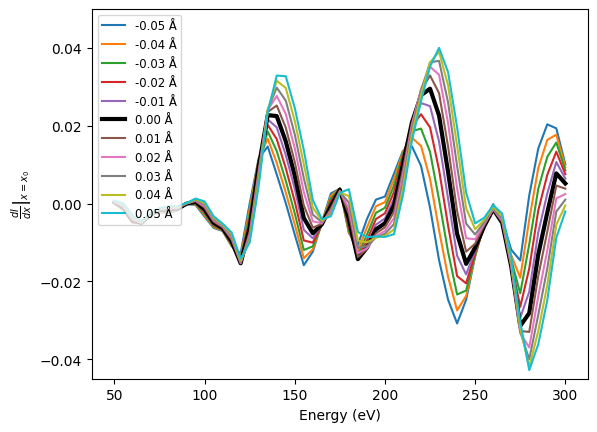

In [20]:
plt.figure()
for i in range(0, 11):
    if i == 5:   
        disp = np.array([[-0.05 + 0.01* i, 0.0, 0.0]]) 
        plt.plot((tensor_data.e_kin-tensor_data.v0r)*HARTREE, jax.jacfwd(delta_intensity)(disp)[:, 0, 0, 0],linewidth=3,color='black',label='0.00 Å')
    else:
        disp = np.array([[-0.05 + 0.01* i, 0.0, 0.0]]) 
        plt.plot((tensor_data.e_kin-tensor_data.v0r)*HARTREE, jax.jacfwd(delta_intensity)(disp)[:, 0, 0, 0],label = str(np.round(-0.05 + 0.01* i,2)) + ' Å')

plt.xlabel("Energy (eV)")
plt.ylabel(r'$\left. \frac{dI}{dx} \right|_{x=x_0}$')
plt.ylim([-0.045,0.05])
plt.legend(fontsize='small', loc='upper left')
plt.show()

In [21]:
estimate_function_cost(delta_intensity, disp)

TracerBoolConversionError: Attempted boolean conversion of traced array with shape bool[]..
The error occurred while tracing the function <lambda> at C:\Users\haide\AppData\Local\Temp\ipykernel_10232\1390258916.py:1 for jit. This value became a tracer due to JAX operations on these lines:

  operation a[35m:bool[51][39m = eq b b
    from line c:\Users\haide\OneDrive\Dokumente\GitHub\on-the-fly-deltas\src\hashable_array.py:23 (__eq__)
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerBoolConversionError

# Interpolation

In [ ]:
from src.interpolation import *

In [ ]:
target_grid = jnp.linspace(e_inside[0], e_inside[-1], 200)
interpolator = StaticNotAKnotSplineInterpolator(e_inside,
                                                target_grid, 3)

In [ ]:
def intensity_interpolated(displacement, beam):
    raw_intensity = delta_intensity(displacement)[:,beam]
    rhs = not_a_knot_rhs(raw_intensity)
    bspline_coeffs = get_bspline_coeffs(interpolator, rhs)
    interpolated_intensity = evaluate_spline(bspline_coeffs, interpolator, 0)
    interpolated_deriv = evaluate_spline(bspline_coeffs, interpolator, 1)
    return interpolated_intensity, interpolated_deriv

Text(0.5, 1.0, 'Interpolated Intensity')

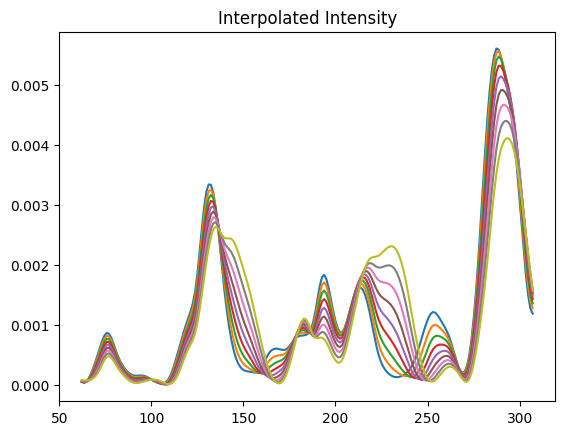

In [ ]:
plt.figure()
for i in range(1, 10):
    disp = np.array([[-0.05 + 0.01* i, 0.0, 0.0]]) 
    plt.plot(target_grid*HARTREE, intensity_interpolated(disp,0)[0])
plt.title("Interpolated Intensity")

Text(0.5, 1.0, 'Interpolated Derivative')

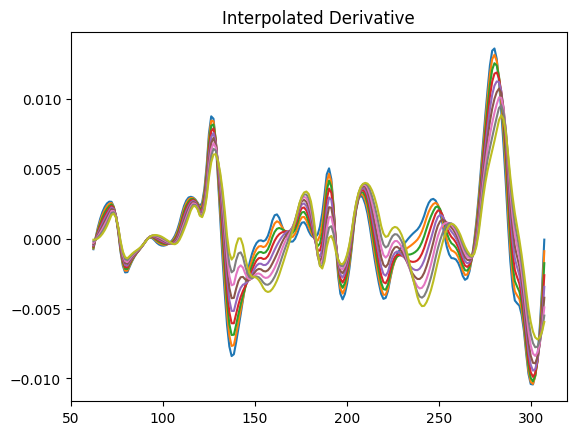

In [ ]:
plt.figure()
for i in range(1, 10):
    disp = np.array([[-0.05 + 0.01* i, 0.0, 0.0]]) 
    plt.plot(target_grid*HARTREE, intensity_interpolated(disp,0)[1])
plt.title("Interpolated Derivative")

In [ ]:
from src.rfactor import *

Text(0.5, 1.0, 'Interpolated Y-function')

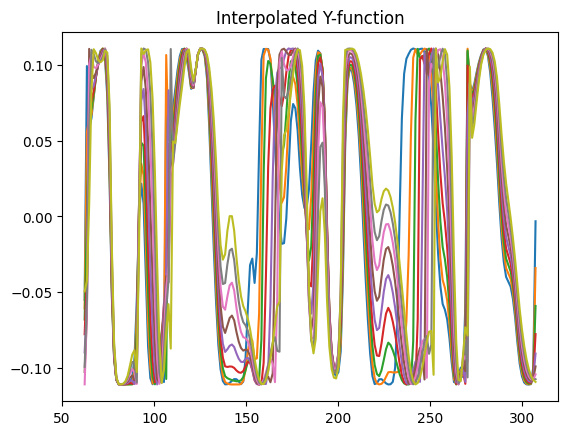

In [ ]:
plt.figure()
for i in range(1, 10):
    disp = np.array([[-0.05 + 0.01* i, 0.0, 0.0]]) 
    plt.plot(target_grid*HARTREE, pendry_y(intensity_interpolated(disp,0)[1],intensity_interpolated(disp,0)[0], 4.5))
plt.title("Interpolated Y-function")

# Rfactor

In [ ]:
from src.rfactor import *

In [ ]:
ref_intensity = delta_intensity(jnp.array([[0.0, 0.0, 0.0],]))[:,0]
R_fun = pendry_R_vs_reference(
    ref_intensity,
    interpolator,
    interpolator,
    4.5,
    3.0,
    0.5,
)

In [ ]:
lam_r = lambda z: jnp.real(R_fun(delta_intensity(jnp.array([[z, 0.0, 0.0],]))[:,0]))

In [ ]:
z_arr = jnp.linspace(-0.05, 0.05, 500)
R_arr = [lam_r(r) for r in z_arr]
R_grad_arr = [jax.grad(lam_r)(r) for r in z_arr]

In [ ]:
plt.figure()
plt.plot(z_arr, R_arr)

In [ ]:
plt.figure()
plt.plot(z_arr, R_grad_arr)

In [ ]:
plt.figure()
plt.plot(z_arr, R_grad_arr)
plt.plot(z_arr[:-1], jnp.diff(np.array(R_arr))/ (z_arr[1]-z_arr[0]))

# R2

In [ ]:
ref_intensity_all_beams = delta_intensity(jnp.array([[0.0, 0.0, 0.0],]))

In [ ]:
lam_r2 = lambda z: jnp.real(((delta_intensity(jnp.array([[z, 0.0, 0.0],])) - ref_intensity_all_beams)**2).sum())

In [ ]:
z_arr = jnp.linspace(-0.05, 0.05, 100)
R2_arr = [lam_r2(r) for r in z_arr]
R2_grad_arr = [jax.grad(lam_r2)(r) for r in z_arr]

In [ ]:
plt.figure()
plt.plot(z_arr, R2_arr)

In [ ]:
plt.figure()
plt.plot(z_arr, R2_grad_arr)

# Timing

In [ ]:
# Function cost
estimate_function_cost(lam_r, 0.0)

In [ ]:
# Function cost
estimate_function_cost(lam_r2, 0.0)

In [ ]:
l = jax.jit(lam_r2).lower(0.0).compile()
%timeit l(0.0)

In [ ]:
l2 = jax.jit(jax.grad(lam_r2)).lower(0.0).compile()
%timeit l2(0.0)